# Libraries importing

In [1]:
import csv
import lightgbm as lgb
import shap
import xgboost as xgb
from datetime import date
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from statistics import mean
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import linalg
from sklearn.gaussian_process import kernels,GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score

# Data loading

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Load the CSV file
file_path= '/content/drive/My Drive/shap_experiment/data'
df_processed_combined_data_daily = pd.read_csv(file_path+"/processed_combined_imputed_with_neighbors_df_processed_combined_data_daily.csv")

#df_aqi_daily.DateTime = pd.to_datetime(df_aqi_daily.DateTime)
df_processed_combined_data_daily.DateTime = pd.to_datetime(df_processed_combined_data_daily.DateTime)
df_PM10_daily = df_processed_combined_data_daily[['DateTime','Bjelave_PM10']]


Mounted at /content/drive


In [ ]:
target_feature="Bjelave_PM10"

# Feature Engineering

In [ ]:
#def add_all_time_features(df, datetime_col='DateTime', target_col='Bjelave_PM10'):
    #df_dt=df.copy()
    #df_dt['Day'] = df[datetime_col].dt.day.astype(np.float64)               # 1.0, 2.0, ..., 31.0
    #df_dt['Month'] = df[datetime_col].dt.month.astype(np.float64)           # 1.0, 2.0, ..., 12.0
    #df_dt['Year'] = df[datetime_col].dt.year.astype(np.float64)
    #return df_dt

In [ ]:
#df_processed_combined_data_daily_dt = add_all_time_features(
    #df=df_processed_combined_data_daily
#)

In [ ]:
#df_processed_combined_data_daily_dt.shape

In [ ]:
#target_feature='Bjelave_PM10'

In [ ]:
#def add_lags(df):
    #target_map = df[target_feature].to_dict()
    #df['Bjelave_PM10_lag30'] = df[target_feature].shift(30)
    #df['Bjelave_PM10_lag20'] = df[target_feature].shift(20)
    #df['Bjelave_PM10_lag15'] = df[target_feature].shift(15)
    #df['Bjelave_PM10_lag7'] = df[target_feature].shift(7)
    #df['Bjelave_PM10_lag1'] = df[target_feature].shift(1)
    #return df

In [ ]:
#df_processed_combined_data_daily_dt = add_lags(df_processed_combined_data_daily_dt)

In [ ]:
#print("df_processed_combined_data_daily.shape: ", df_processed_combined_data_daily_dt.shape)
#df_processed_combined_data_daily_dt=df_processed_combined_data_daily_dt.dropna()
#print("df_processed_combined_data_daily.shape: ", df_processed_combined_data_daily_dt.shape)

In [ ]:
#df_processed_combined_data_daily_dt.tail(2)

# Dataset Splitting

In [ ]:
features=df_processed_combined_data_daily.columns
features

Index(['DateTime', 'wind_speed', 'wind_direction', 'precipitation', 'pressure',
       'temperature', 'humidity', 'visibility', 'cloudiness', 'Bjelave_PM10',
       'Bjelave_SO2', 'Bjelave_NO2'],
      dtype='object')

In [ ]:
def train_val_test_split(df, test_size, val_size=None, date_column='DateTime'):
    df = df.copy().sort_values(by=date_column)

    if val_size is None:
        val_size = test_size

    test_start_date = df[date_column].iloc[-test_size]
    val_start_date = df[date_column].iloc[-(test_size + val_size)]

    train_data = df[df[date_column] < val_start_date].copy()
    val_data = df[(df[date_column] >= val_start_date) & (df[date_column] < test_start_date)].copy()
    test_data = df[df[date_column] >= test_start_date].copy()

    print(f"Trening skup: {len(train_data)} uzoraka")
    print(f"Validacijski skup: {len(val_data)} uzoraka")
    print(f"Test skup: {len(test_data)} uzoraka")

    return train_data, val_data, test_data

In [ ]:
def plot_train_val_test_data(train_data, val_data, test_data, date_column='DateTime', label='Bjelave_PM10'):
    plt.figure(figsize=(20,10))
    plt.plot(train_data[date_column], train_data[label], color='blue', label='Train Data', alpha=0.8)
    plt.plot(val_data[date_column], val_data[label], color='green', label='Validation Data', alpha=0.8)
    plt.plot(test_data[date_column], test_data[label], color='orange', label='Test Data', alpha=0.8)
    plt.xlabel(date_column)
    plt.ylabel(label)
    plt.title(f'{label} - Train, Validation and Test Data')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [ ]:
horizons = [1,2,3,7,15,30,60]

In [ ]:
def add_lags(df, horizon):
    for feature in features:
      df[feature] = df[feature].shift(horizon)
    return df

In [ ]:
def set_column_as_index(df, column_name='DateTime'):
  if column_name in df.columns:
    df.set_index(column_name, inplace=True)

In [ ]:
def plot_boxplot(prediction_data, test_data):
    error = abs(prediction_data - test_data)
    # plot boxplot of error
    plt.figure(figsize=(10,6))
    plt.boxplot(error)
    plt.show()

In [ ]:
df_processed_combined_data_daily.tail(3)

,DateTime,wind_speed,wind_direction,precipitation,pressure,temperature,humidity,visibility,cloudiness,Bjelave_PM10,Bjelave_SO2,Bjelave_NO2
1823,2022-12-29,2.187500,146.166667,0.0,947.341667,5.354167,81.666667,18812.500000,4.1875,50.187371,25.431842,38.493039
1824,2022-12-30,1.070833,159.541667,0.0,947.279167,6.429167,79.083333,19416.666667,4.0000,67.841704,27.591008,54.974991
1825,2022-12-31,2.050000,128.875000,0.0,952.166667,6.670833,77.708333,18812.500000,2.7750,48.536400,24.678667,32.047637


In [ ]:
ds=[]

In [ ]:
#input window = 1
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=1)
#train_data_combined_ws_day, test_data_combined_ws_day = train_test_split(df_processed_combined_data_daily, date)
train_data_combined_ws_day, val_data_combined_ws_day, test_data_combined_ws_day = train_val_test_split(df_processed_combined_data_daily, 2)
ds.append(train_data_combined_ws_day)
ds.append(test_data_combined_ws_day)
ds.append(val_data_combined_ws_day)

#input window = 2
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=3)
#train_data_combined_ws_two_days, test_data_combined_ws_two_days = train_test_split(df_processed_combined_data_daily, date) #
train_data_combined_ws_two_days, val_data_combined_ws_two_days, test_data_combined_ws_two_days = train_val_test_split(df_processed_combined_data_daily, 4)
ds.append(train_data_combined_ws_two_days)
ds.append(test_data_combined_ws_two_days)
ds.append(val_data_combined_ws_two_days)

#input window = 3
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=5)
#train_data_combined_ws_three_days, test_data_combined_ws_three_days = train_test_split(df_processed_combined_data_daily, date) #
train_data_combined_ws_three_days, val_data_combined_ws_three_days, test_data_combined_ws_three_days = train_val_test_split(df_processed_combined_data_daily, 6)
ds.append(train_data_combined_ws_three_days)
ds.append(test_data_combined_ws_three_days)
ds.append(val_data_combined_ws_three_days)

#input window = 7
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=13)
#train_data_combined_ws_week, test_data_combined_ws_week = train_test_split(df_processed_combined_data_daily, date) #
train_data_combined_ws_week, val_data_combined_ws_week, test_data_combined_ws_week = train_val_test_split(df_processed_combined_data_daily, 14)
ds.append(train_data_combined_ws_week)
ds.append(test_data_combined_ws_week)
ds.append(val_data_combined_ws_week)

#input window = 15
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=29)
#train_data_combined_ws_fifteen, test_data_combined_ws_fifteen = train_test_split(df_processed_combined_data_daily, date) #
train_data_combined_ws_fifteen, val_data_combined_ws_fifteen, test_data_combined_ws_fifteen = train_val_test_split(df_processed_combined_data_daily, 30)
ds.append(train_data_combined_ws_fifteen)
ds.append(test_data_combined_ws_fifteen)
ds.append(val_data_combined_ws_fifteen)

#input window = 30
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=59)
#train_data_combined_ws_thirty, test_data_combined_ws_thirty = train_test_split(df_processed_combined_data_daily, date) # #train_PM10_daily_ws_thirty, test_PM10_daily_ws_thirty = train_test_split(df_PM10_daily, date)
#ds.append(train_data_combined_ws_thirty)
#ds.append(test_data_combined_ws_thirty)
train_data_combined_ws_thirty, val_data_combined_ws_thirty, test_data_combined_ws_thirty = train_val_test_split(df_processed_combined_data_daily, 60)
ds.append(train_data_combined_ws_thirty)
ds.append(test_data_combined_ws_thirty)
ds.append(val_data_combined_ws_thirty)


#input window = 60
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=119)
#train_data_combined_ws_sixty, test_data_combined_ws_sixty = train_test_split(df_processed_combined_data_daily, date) #train_PM10_daily_ws_sixty, test_PM10_daily_ws_sixty = train_test_split(df_PM10_daily, date)
train_data_combined_ws_sixty, val_data_combined_ws_sixty, test_data_combined_ws_sixty = train_val_test_split(df_processed_combined_data_daily, 120)
ds.append(train_data_combined_ws_sixty)
ds.append(test_data_combined_ws_sixty)
ds.append(val_data_combined_ws_sixty)

Trening skup: 1822 uzoraka
Validacijski skup: 2 uzoraka
Test skup: 2 uzoraka
Trening skup: 1818 uzoraka
Validacijski skup: 4 uzoraka
Test skup: 4 uzoraka
Trening skup: 1814 uzoraka
Validacijski skup: 6 uzoraka
Test skup: 6 uzoraka
Trening skup: 1798 uzoraka
Validacijski skup: 14 uzoraka
Test skup: 14 uzoraka
Trening skup: 1766 uzoraka
Validacijski skup: 30 uzoraka
Test skup: 30 uzoraka
Trening skup: 1706 uzoraka
Validacijski skup: 60 uzoraka
Test skup: 60 uzoraka
Trening skup: 1586 uzoraka
Validacijski skup: 120 uzoraka
Test skup: 120 uzoraka


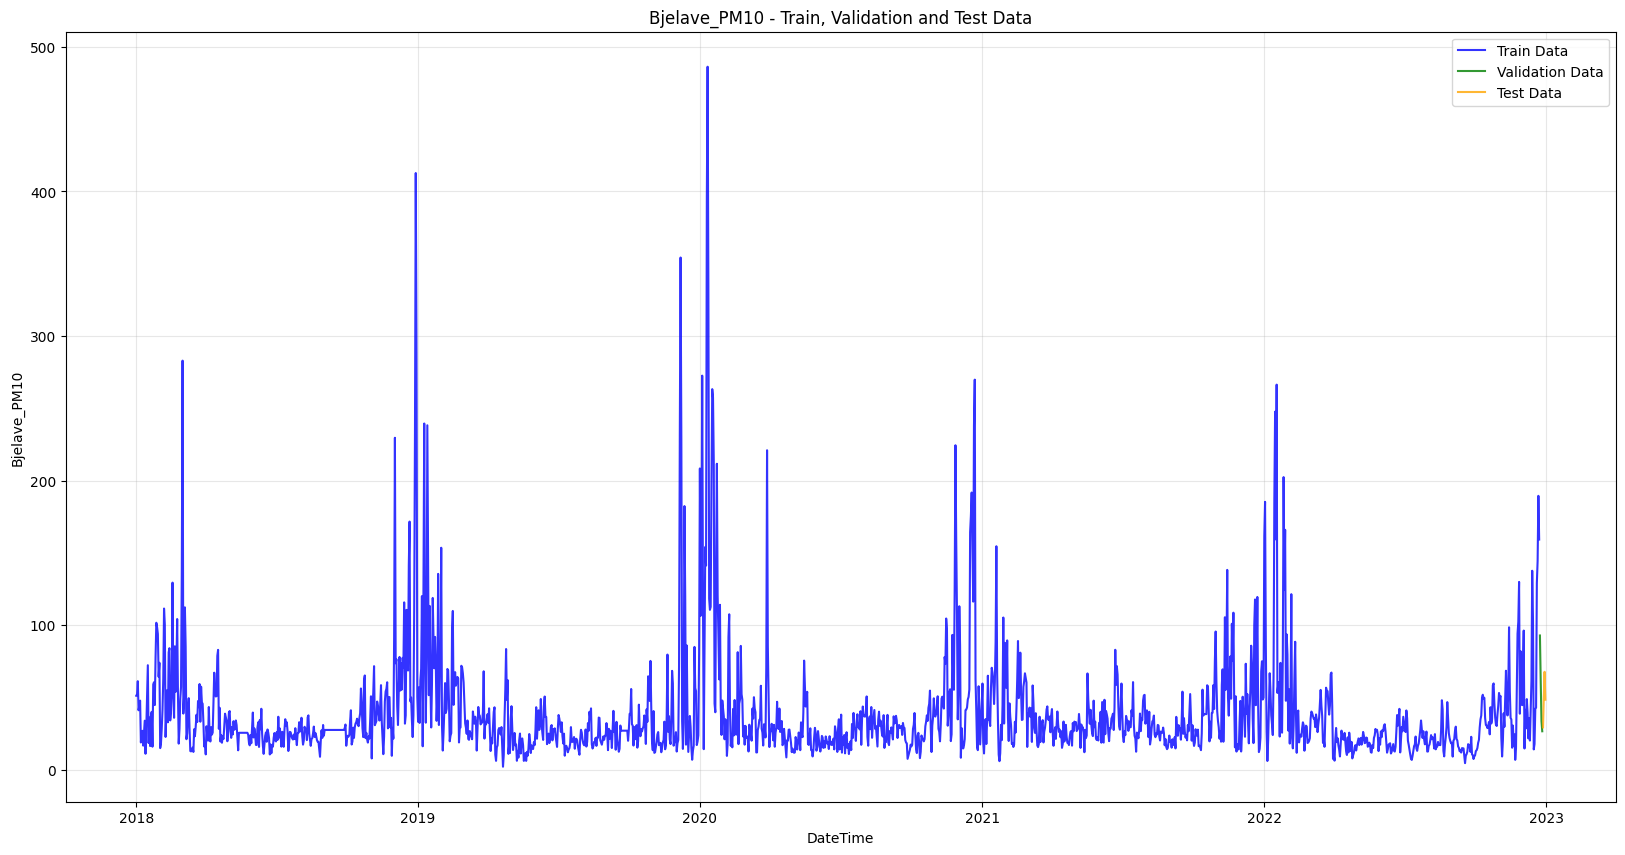

In [ ]:
plot_train_val_test_data(train_data_combined_ws_two_days, val_data_combined_ws_two_days, test_data_combined_ws_two_days)

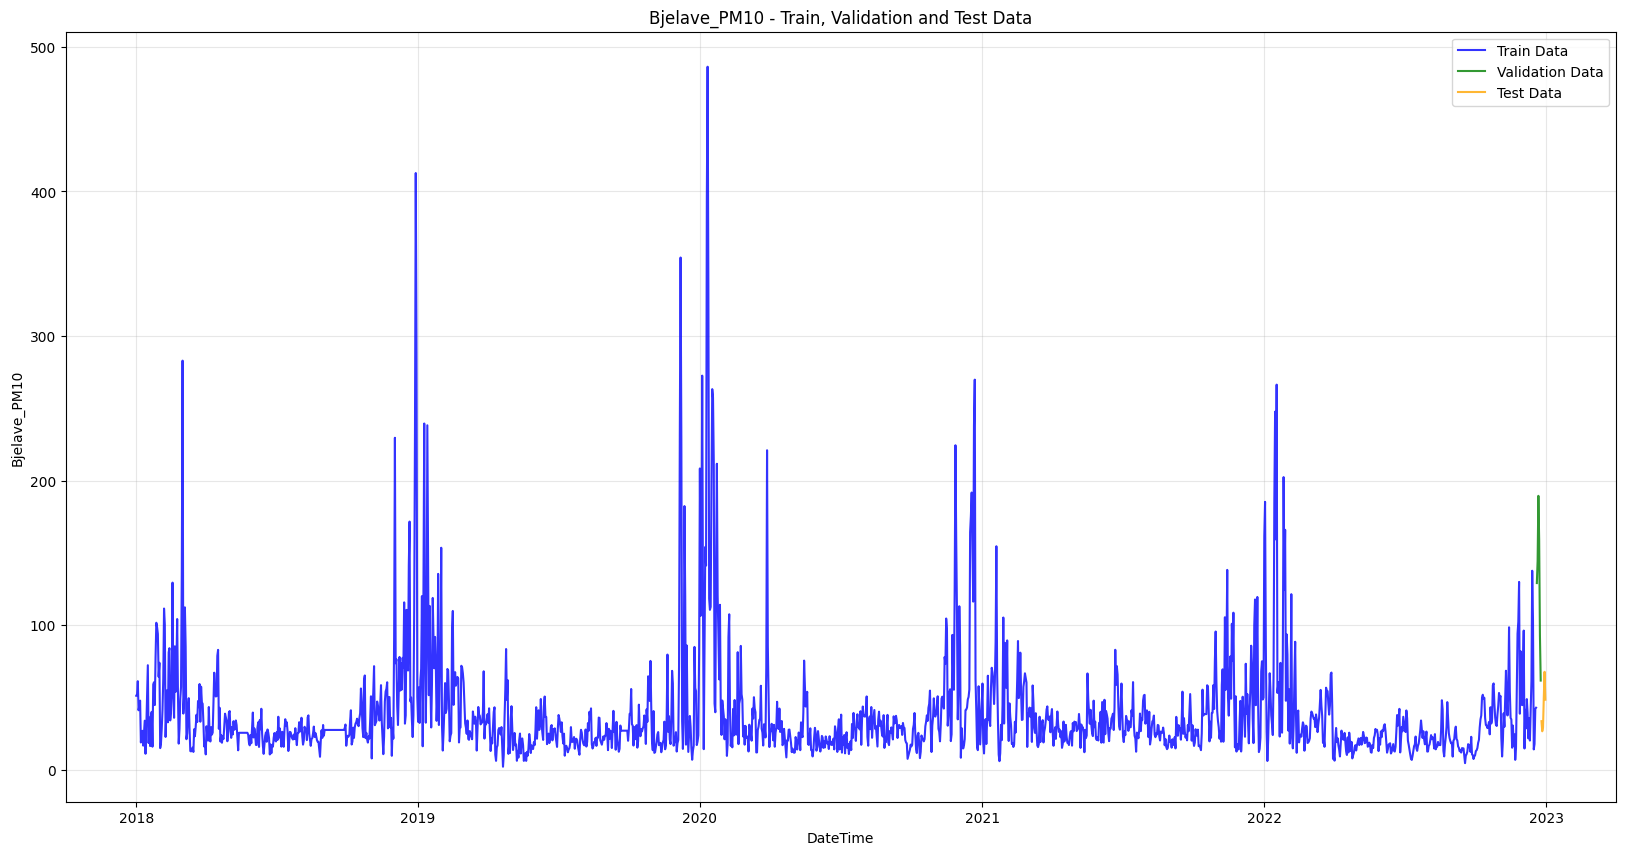

In [ ]:
plot_train_val_test_data(train_data_combined_ws_three_days, val_data_combined_ws_three_days, test_data_combined_ws_three_days)

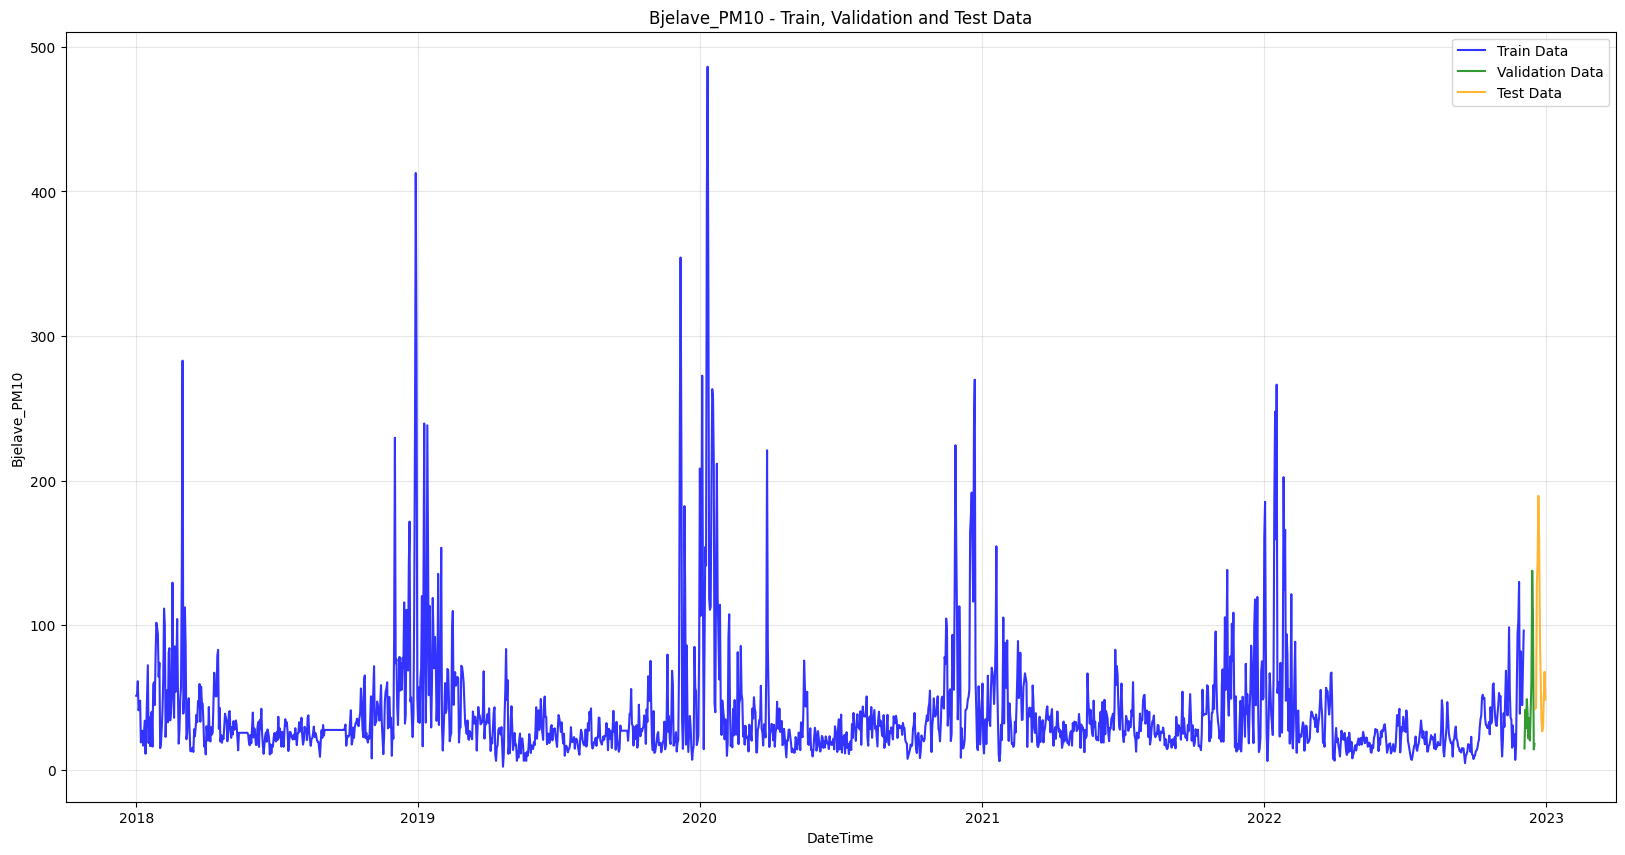

In [ ]:
plot_train_val_test_data(train_data_combined_ws_week, val_data_combined_ws_week, test_data_combined_ws_week)

In [ ]:
for set in ds:
  set_column_as_index(set)

In [ ]:
def features_target_split(horizon, df, target_feature="Bjelave_PM10"):
  X = df.iloc[:df.shape[0]-horizon]
  y = df[[target_feature]].iloc[horizon:df.shape[0]]
  return X, y

def rename_targets(y_train, y_val, y_test):
  y_train = y_train.rename(columns={target_feature: f'{target_feature}_predicted'}, inplace=True)
  y_val = y_val.rename(columns={target_feature: f'{target_feature}_predicted'}, inplace=True)
  y_test = y_test.rename(columns={target_feature: f'{target_feature}_predicted'}, inplace=True)

In [ ]:
horizon=1
# train_data_combined_ws_day, val_data_combined_ws_day, test_data_combined_ws_day
X_train_day, y_train_day = features_target_split(horizon, train_data_combined_ws_day)
X_val_day, y_val_day = features_target_split(horizon, val_data_combined_ws_day)
X_test_day, y_test_day = features_target_split(horizon, val_data_combined_ws_day)
rename_targets(y_train_day, y_val_day, y_test_day)

In [ ]:
horizon=2
# train_data_combined_ws_two_days, val_data_combined_ws_two_days, test_data_combined_ws_two_days
X_train_two_days, y_train_two_days = features_target_split(horizon, train_data_combined_ws_two_days)
X_val_two_days, y_val_two_days = features_target_split(horizon, val_data_combined_ws_two_days)
X_test_two_days, y_test_two_days = features_target_split(horizon, test_data_combined_ws_two_days)
rename_targets(y_train_two_days, y_val_two_days, y_test_two_days)

In [ ]:
horizon=3
# train_data_combined_ws_three_days, val_data_combined_ws_three_days, test_data_combined_ws_three_days
X_train_three_days, y_train_three_days = features_target_split(horizon, train_data_combined_ws_three_days)
X_val_three_days, y_val_three_days = features_target_split(horizon, val_data_combined_ws_three_days)
X_test_three_days, y_test_three_days = features_target_split(horizon, test_data_combined_ws_three_days)
rename_targets(y_train_three_days, y_val_three_days, y_test_three_days)

In [ ]:
horizon=7
# train_data_combined_ws_week, val_data_combined_ws_week, test_data_combined_ws_week
X_train_week, y_train_week = features_target_split(horizon, train_data_combined_ws_week)
X_val_week, y_val_week = features_target_split(horizon, val_data_combined_ws_week)
X_test_week, y_test_week = features_target_split(horizon, test_data_combined_ws_week)
rename_targets(y_train_week, y_val_week, y_test_week)

In [ ]:
horizon=15
# train_data_combined_ws_fifteen, val_data_combined_ws_fifteen, test_data_combined_ws_fifteen
X_train_fifteen, y_train_fifteen = features_target_split(horizon, train_data_combined_ws_fifteen)
X_val_fifteen, y_val_fifteen = features_target_split(horizon, val_data_combined_ws_fifteen)
X_test_fifteen, y_test_fifteen = features_target_split(horizon, test_data_combined_ws_fifteen)
rename_targets(y_train_fifteen, y_val_fifteen, y_test_fifteen)

In [ ]:
horizon=30
# train_data_combined_ws_thirty, val_data_combined_ws_thirty, test_data_combined_ws_thirty
X_train_thirty, y_train_thirty = features_target_split(horizon, train_data_combined_ws_thirty)
X_val_thirty, y_val_thirty = features_target_split(horizon, val_data_combined_ws_thirty)
X_test_thirty, y_test_thirty = features_target_split(horizon, test_data_combined_ws_thirty)
rename_targets(y_train_thirty, y_val_thirty, y_test_thirty)

In [ ]:
horizon=60
# train_data_combined_ws_sixty, val_data_combined_ws_sixty, test_data_combined_ws_sixty
X_train_sixty, y_train_sixty = features_target_split(horizon, train_data_combined_ws_sixty)
X_val_sixty, y_val_sixty = features_target_split(horizon, val_data_combined_ws_sixty)
X_test_sixty, y_test_sixty = features_target_split(horizon, test_data_combined_ws_sixty)
rename_targets(y_train_sixty, y_val_sixty, y_test_sixty)

In [ ]:
test_data_combined_ws_two_days[]

,wind_speed,wind_direction,precipitation,pressure,temperature,humidity,visibility,cloudiness,Bjelave_PM10,Bjelave_SO2,Bjelave_NO2
DateTime,,,,,,,,,,,
2022-12-28,1.450000,179.125000,0.0,949.583333,4.591667,82.208333,19416.666667,4.9375,29.372987,23.098171,32.184576
2022-12-29,2.187500,146.166667,0.0,947.341667,5.354167,81.666667,18812.500000,4.1875,50.187371,25.431842,38.493039
2022-12-30,1.070833,159.541667,0.0,947.279167,6.429167,79.083333,19416.666667,4.0000,67.841704,27.591008,54.974991
2022-12-31,2.050000,128.875000,0.0,952.166667,6.670833,77.708333,18812.500000,2.7750,48.536400,24.678667,32.047637


In [ ]:
X_test_two_days

,wind_speed,wind_direction,precipitation,pressure,temperature,humidity,visibility,cloudiness,Bjelave_PM10,Bjelave_SO2,Bjelave_NO2
DateTime,,,,,,,,,,,
2022-12-28,1.4500,179.125000,0.0,949.583333,4.591667,82.208333,19416.666667,4.9375,29.372987,23.098171,32.184576
2022-12-29,2.1875,146.166667,0.0,947.341667,5.354167,81.666667,18812.500000,4.1875,50.187371,25.431842,38.493039


In [ ]:
y_test_two_days

,Bjelave_PM10_predicted
DateTime,
2022-12-30,67.841704
2022-12-31,48.536400


# Time Series Forecasting with XGBoost

In [ ]:
target_feature="Bjelave_PM10"

In [ ]:
train_data_combined_ws_thirty.shape[0]

1706

In [ ]:
# 1 day
reg_ws_day = xgb.XGBRegressor(
    n_estimators=400,
    early_stopping_rounds=60,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=25,
    subsample=0.5,
    colsample_bytree=0.5,
    gamma=1,
    reg_alpha=3.0,
    reg_lambda=5.0
)

reg_ws_day.fit(X_train_day, y_train_day,
    eval_set=[
        (X_train_day, y_train_day),
        (X_val_day, y_val_day)
    ], verbose=1)

[0]	validation_0-rmse:38.32868	validation_1-rmse:10.75612
[1]	validation_0-rmse:37.76409	validation_1-rmse:11.08778
[2]	validation_0-rmse:37.01361	validation_1-rmse:11.27551
[3]	validation_0-rmse:36.60736	validation_1-rmse:10.38679
[4]	validation_0-rmse:36.19220	validation_1-rmse:10.54232
[5]	validation_0-rmse:35.54875	validation_1-rmse:10.72056
[6]	validation_0-rmse:35.21074	validation_1-rmse:8.45473
[7]	validation_0-rmse:34.77927	validation_1-rmse:5.12344
[8]	validation_0-rmse:34.40066	validation_1-rmse:3.84853
[9]	validation_0-rmse:33.90017	validation_1-rmse:4.05704
[10]	validation_0-rmse:33.48936	validation_1-rmse:3.16753
[11]	validation_0-rmse:33.03469	validation_1-rmse:3.48253
[12]	validation_0-rmse:32.66885	validation_1-rmse:0.92682
[13]	validation_0-rmse:32.18921	validation_1-rmse:1.35737
[14]	validation_0-rmse:31.78778	validation_1-rmse:1.30034
[15]	validation_0-rmse:31.52060	validation_1-rmse:0.17444
[16]	validation_0-rmse:31.22060	validation_1-rmse:0.17857
[17]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=25, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 2 day
# train_data_combined_ws_two_days, val_data_combined_ws_two_days, test_data_combined_ws_two_days
#reg_ws_two_days = xgb.XGBRegressor(n_estimators=200, early_stopping_rounds=60, learning_rate=0.01, max_depth=2,
 #                                  min_child_weight=50, subsample=0.3, colsample_bytree=0.5, gamma=1,reg_alpha=20.0,
  #                                 reg_lambda=15.0)
reg_ws_two_days = xgb.XGBRegressor()
reg_ws_two_days.fit(X_train_two_days, y_train_two_days,
    eval_set=[
        (X_train_two_days, y_train_two_days),
        (X_val_two_days, y_val_two_days)
    ], verbose=1)

[0]	validation_0-rmse:32.16353	validation_1-rmse:12.56752
[1]	validation_0-rmse:27.29816	validation_1-rmse:12.55404
[2]	validation_0-rmse:23.81452	validation_1-rmse:13.06074
[3]	validation_0-rmse:20.98026	validation_1-rmse:16.09594
[4]	validation_0-rmse:18.76105	validation_1-rmse:14.59674
[5]	validation_0-rmse:16.90633	validation_1-rmse:17.70578
[6]	validation_0-rmse:15.47587	validation_1-rmse:17.52734
[7]	validation_0-rmse:14.59555	validation_1-rmse:16.29401
[8]	validation_0-rmse:13.77923	validation_1-rmse:17.09658
[9]	validation_0-rmse:13.27929	validation_1-rmse:16.94343
[10]	validation_0-rmse:12.82858	validation_1-rmse:16.49680
[11]	validation_0-rmse:12.25052	validation_1-rmse:17.46886
[12]	validation_0-rmse:11.91461	validation_1-rmse:17.36554
[13]	validation_0-rmse:11.66149	validation_1-rmse:17.78569
[14]	validation_0-rmse:11.33750	validation_1-rmse:18.11856
[15]	validation_0-rmse:11.17597	validation_1-rmse:18.53244
[16]	validation_0-rmse:10.72437	validation_1-rmse:18.68410
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 3 days
# train_data_combined_ws_three_days, val_data_combined_ws_three_days, test_data_combined_ws_three_days
reg_ws_three_days = xgb.XGBRegressor(
    n_estimators=400,
    early_stopping_rounds=20,
    learning_rate=0.08,
    max_depth=3,
    min_child_weight=25,
    subsample=0.5,
    colsample_bytree=0.5,
    gamma=1,
    reg_alpha=3.0,
    reg_lambda=5.0
)

reg_ws_three_days.fit(X_train_three_days, y_train_three_days,
    eval_set=[
        (X_train_three_days, y_train_three_days),
        (X_val_three_days, y_val_three_days)
    ], verbose=1)

[0]	validation_0-rmse:37.76982	validation_1-rmse:73.76042
[1]	validation_0-rmse:37.32097	validation_1-rmse:72.78491
[2]	validation_0-rmse:36.68678	validation_1-rmse:71.11813
[3]	validation_0-rmse:36.40880	validation_1-rmse:69.66598
[4]	validation_0-rmse:36.11868	validation_1-rmse:68.76902
[5]	validation_0-rmse:35.84453	validation_1-rmse:67.97907
[6]	validation_0-rmse:35.46526	validation_1-rmse:67.23575
[7]	validation_0-rmse:34.95845	validation_1-rmse:66.62419
[8]	validation_0-rmse:34.70589	validation_1-rmse:65.86997
[9]	validation_0-rmse:34.17792	validation_1-rmse:63.59912
[10]	validation_0-rmse:33.77312	validation_1-rmse:62.69002
[11]	validation_0-rmse:33.57338	validation_1-rmse:61.68578
[12]	validation_0-rmse:33.28877	validation_1-rmse:61.22359
[13]	validation_0-rmse:32.79602	validation_1-rmse:58.29887
[14]	validation_0-rmse:32.55069	validation_1-rmse:57.62668
[15]	validation_0-rmse:32.32404	validation_1-rmse:57.71706
[16]	validation_0-rmse:32.01119	validation_1-rmse:55.76794
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=25, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 7 days (week)
#train_data_combined_ws_week, val_data_combined_ws_week, test_data_combined_ws_week

reg_ws_week = xgb.XGBRegressor(
    n_estimators=400,
    early_stopping_rounds=60,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=25,
    subsample=0.5,
    colsample_bytree=0.5,
    gamma=1,
    reg_alpha=3.0,
    reg_lambda=5.0
)

reg_ws_week.fit(X_train_week, y_train_week,
    eval_set=[
        (X_train_week, y_train_week),
        (X_val_week, y_val_week)
    ], verbose=1)

[0]	validation_0-rmse:38.43946	validation_1-rmse:47.33976
[1]	validation_0-rmse:38.14732	validation_1-rmse:46.81604
[2]	validation_0-rmse:37.83123	validation_1-rmse:46.28670
[3]	validation_0-rmse:37.64093	validation_1-rmse:46.01435
[4]	validation_0-rmse:37.47825	validation_1-rmse:45.84829
[5]	validation_0-rmse:37.25808	validation_1-rmse:45.66387
[6]	validation_0-rmse:37.11305	validation_1-rmse:45.19781
[7]	validation_0-rmse:36.87836	validation_1-rmse:44.64912
[8]	validation_0-rmse:36.69014	validation_1-rmse:44.35735
[9]	validation_0-rmse:36.43500	validation_1-rmse:44.06877
[10]	validation_0-rmse:36.21734	validation_1-rmse:43.92442
[11]	validation_0-rmse:36.06409	validation_1-rmse:43.77634
[12]	validation_0-rmse:35.91615	validation_1-rmse:43.30533
[13]	validation_0-rmse:35.75711	validation_1-rmse:42.86494
[14]	validation_0-rmse:35.56548	validation_1-rmse:42.59375
[15]	validation_0-rmse:35.46508	validation_1-rmse:42.08453
[16]	validation_0-rmse:35.28666	validation_1-rmse:41.98250
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=25, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
import pandas as pd
correlations = X_train_ws_week.corrwith(y_train_ws_week)
print(correlations.sort_values(ascending=False))

Bjelave_PM10      1.000000
Bjelave_NO2       0.606946
Bjelave_SO2       0.365149
humidity          0.273955
pressure          0.232377
cloudiness        0.023470
wind_direction   -0.025586
precipitation    -0.113110
wind_speed       -0.291658
temperature      -0.396182
visibility       -0.467901
dtype: float64


In [ ]:
# 15 days
# train_data_combined_ws_fifteen, val_data_combined_ws_fifteen, test_data_combined_ws_fifteen

reg_ws_fifteen = xgb.XGBRegressor(
    n_estimators=400,
    early_stopping_rounds=60,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=25,
    subsample=0.5,
    colsample_bytree=0.5,
    gamma=1,
    reg_alpha=3.0,
    reg_lambda=5.0
)

reg_ws_fifteen.fit(X_train_fifteen, y_train_fifteen,
    eval_set=[
        (X_train_fifteen, y_train_fifteen),
        (X_val_fifteen, y_val_fifteen)
    ], verbose=1)

[0]	validation_0-rmse:38.64987	validation_1-rmse:37.55551
[1]	validation_0-rmse:38.43702	validation_1-rmse:37.34549
[2]	validation_0-rmse:38.20413	validation_1-rmse:37.16749
[3]	validation_0-rmse:38.03337	validation_1-rmse:36.93977
[4]	validation_0-rmse:37.86037	validation_1-rmse:36.73065
[5]	validation_0-rmse:37.72067	validation_1-rmse:36.30029
[6]	validation_0-rmse:37.53839	validation_1-rmse:36.09496
[7]	validation_0-rmse:37.33721	validation_1-rmse:35.43273
[8]	validation_0-rmse:37.19329	validation_1-rmse:35.13813
[9]	validation_0-rmse:37.01014	validation_1-rmse:34.98965
[10]	validation_0-rmse:36.86300	validation_1-rmse:34.90869
[11]	validation_0-rmse:36.72159	validation_1-rmse:34.60111
[12]	validation_0-rmse:36.56731	validation_1-rmse:34.32845
[13]	validation_0-rmse:36.47485	validation_1-rmse:34.27447
[14]	validation_0-rmse:36.37619	validation_1-rmse:34.10947
[15]	validation_0-rmse:36.30813	validation_1-rmse:33.92866
[16]	validation_0-rmse:36.16836	validation_1-rmse:33.78549
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=25, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
import pandas as pd
correlations = X_train_ws_fifteen.corrwith(y_train_ws_fifteen)
print(correlations.sort_values(ascending=False))

Bjelave_PM10      1.000000
Bjelave_NO2       0.607325
Bjelave_SO2       0.364760
humidity          0.278631
pressure          0.230735
cloudiness        0.026979
wind_direction   -0.023623
precipitation    -0.110439
wind_speed       -0.291068
temperature      -0.398663
visibility       -0.476290
dtype: float64


In [ ]:
# 30 days
# train_data_combined_ws_thirty, val_data_combined_ws_thirty, test_data_combined_ws_thirty
reg_ws_thirty = xgb.XGBRegressor(
    n_estimators=400,
    early_stopping_rounds=60,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=25,
    subsample=0.5,
    colsample_bytree=0.5,
    gamma=1,
    reg_alpha=3.0,
    reg_lambda=5.0
)

reg_ws_thirty.fit(X_train_thirty, y_train_thirty,
    eval_set=[
        (X_train_thirty, y_train_thirty),
        (X_val_thirty, y_val_thirty)
    ], verbose=1)

[0]	validation_0-rmse:39.30151	validation_1-rmse:12.07652
[1]	validation_0-rmse:39.11897	validation_1-rmse:12.04241
[2]	validation_0-rmse:38.93572	validation_1-rmse:12.00813
[3]	validation_0-rmse:38.78718	validation_1-rmse:12.02938
[4]	validation_0-rmse:38.63060	validation_1-rmse:11.95115
[5]	validation_0-rmse:38.50669	validation_1-rmse:12.04165
[6]	validation_0-rmse:38.41396	validation_1-rmse:12.10967
[7]	validation_0-rmse:38.25159	validation_1-rmse:12.14066
[8]	validation_0-rmse:38.09889	validation_1-rmse:12.22918
[9]	validation_0-rmse:37.98639	validation_1-rmse:12.18012
[10]	validation_0-rmse:37.85309	validation_1-rmse:12.23562
[11]	validation_0-rmse:37.75287	validation_1-rmse:12.42957
[12]	validation_0-rmse:37.65274	validation_1-rmse:12.48254
[13]	validation_0-rmse:37.54191	validation_1-rmse:12.56138
[14]	validation_0-rmse:37.44719	validation_1-rmse:12.54332
[15]	validation_0-rmse:37.31951	validation_1-rmse:12.62084
[16]	validation_0-rmse:37.25024	validation_1-rmse:12.65073
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=25, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 60 days
# train_data_combined_ws_sixty, val_data_combined_ws_sixty, test_data_combined_ws_sixty
reg_ws_sixty = xgb.XGBRegressor(
    n_estimators=400,
    early_stopping_rounds=60,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=25,
    subsample=0.5,
    colsample_bytree=0.5,
    gamma=1,
    reg_alpha=3.0,
    reg_lambda=5.0
)

reg_ws_sixty.fit(X_train_sixty, y_train_sixty,
    eval_set=[
        (X_train_sixty, y_train_sixty),
        (X_val_sixty, y_val_sixty)
    ], verbose=1)

[0]	validation_0-rmse:40.63939	validation_1-rmse:20.51472
[1]	validation_0-rmse:40.54847	validation_1-rmse:20.16570
[2]	validation_0-rmse:40.46280	validation_1-rmse:19.86604
[3]	validation_0-rmse:40.38640	validation_1-rmse:19.62296
[4]	validation_0-rmse:40.33028	validation_1-rmse:19.50076
[5]	validation_0-rmse:40.29622	validation_1-rmse:19.42880
[6]	validation_0-rmse:40.22781	validation_1-rmse:19.34162
[7]	validation_0-rmse:40.17073	validation_1-rmse:19.15807
[8]	validation_0-rmse:40.08172	validation_1-rmse:19.06535
[9]	validation_0-rmse:40.02483	validation_1-rmse:18.85092
[10]	validation_0-rmse:39.96604	validation_1-rmse:18.56106
[11]	validation_0-rmse:39.85425	validation_1-rmse:18.50187
[12]	validation_0-rmse:39.77429	validation_1-rmse:18.31157
[13]	validation_0-rmse:39.70866	validation_1-rmse:18.14792
[14]	validation_0-rmse:39.67816	validation_1-rmse:17.99048
[15]	validation_0-rmse:39.63246	validation_1-rmse:17.81538
[16]	validation_0-rmse:39.54511	validation_1-rmse:17.84278
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=60,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=25, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

# Predicting the Future

one day

In [ ]:
def evaluate_forecasts(actual_data, predicted_data):
  rmse = np.sqrt(mean_squared_error(actual_data, predicted_data))
  mae = mean_absolute_error(actual_data, predicted_data)
  r2 = r2_score(actual_data, predicted_data)
  print("RMSE:", rmse)
  print("MAE:", mae)
  print("R2 Score:", r2)
  return rmse, mae, r2
  #test_data_combined_ws_three_days.index

In [ ]:
def create_pred_df(y_index, predictions, target_column=target_feature, date_column='DateTime'):
    pred_df = pd.DataFrame({
        date_column: y_index,
        target_column: predictions
    })

    return pred_df

In [ ]:
## train_data_combined_ws_day, val_data_combined_ws_day, test_data_combined_ws_day = train_val_test_split(df_processed_combined_data_daily, 2)

prediction_ws_day = reg_ws_day.predict(X_val_day)
prediction_ws_day = create_pred_df(y_val_day.index, prediction_ws_day)

In [ ]:
prediction_ws_day

,DateTime,Bjelave_PM10
0,2022-12-29,50.109108


In [ ]:
(rmse_ws_ws_day, mae_ws_day, r2_ws_day) = evaluate_forecasts(y_val_day, prediction_ws_day['Bjelave_PM10'])

RMSE: 0.07826232761406111
MAE: 0.0782623291015625
R2 Score: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


two days

In [ ]:
prediction_ws_two_days = reg_ws_two_days.predict(X_val_two_days)
prediction_ws_two_days = create_pred_df(y_val_two_days.index, prediction_ws_two_days)

In [ ]:
(rmse_ws_two_days, mae_ws_two_days, r2_ws_two_days) = evaluate_forecasts(y_val_two_days, prediction_ws_two_days['Bjelave_PM10'])

RMSE: 19.69471516473193
MAE: 18.25647735595703
R2 Score: -30.636627197265625


In [ ]:
#val_data_combined_ws_two_days[target_feature]

In [ ]:
prediction_ws_two_days = reg_ws_two_days.predict(X_test_two_days)
prediction_ws_two_days = create_pred_df(y_test_two_days.index, prediction_ws_two_days)

In [ ]:
(rmse_ws_two_days, mae_ws_two_days, r2_ws_two_days) = evaluate_forecasts(y_test_two_days, prediction_ws_two_days['Bjelave_PM10'])

RMSE: 5.856308442336123
MAE: 5.8358612060546875
R2 Score: 0.6319096088409424


In [ ]:
print("VAL target stats:", y_val_two_days.describe())
print("TEST target stats:", y_test_two_days.describe())


VAL target stats:        Bjelave_PM10_predicted
count                2.000000
mean                30.216101
std                  4.951873
min                 26.714598
25%                 28.465350
50%                 30.216101
75%                 31.966853
max                 33.717604
TEST target stats:        Bjelave_PM10_predicted
count                2.000000
mean                58.189052
std                 13.650912
min                 48.536400
25%                 53.362726
50%                 58.189052
75%                 63.015378
max                 67.841704


three days

In [ ]:
prediction_ws_three_days = reg_ws_three_days.predict(X_val_three_days)
prediction_ws_three_days=create_pred_df(y_val_three_days.index, prediction_ws_three_days)


In [ ]:
(rmse_ws_three_days, mae_ws_three_days, r2_ws_three_days) = evaluate_forecasts(y_val_three_days, prediction_ws_three_days['Bjelave_PM10'])

RMSE: 43.864416514218135
MAE: 35.31220626831055
R2 Score: -0.1635115146636963


In [ ]:
prediction_ws_three_days = reg_ws_three_days.predict(X_test_three_days)
prediction_ws_three_days=create_pred_df(y_test_three_days.index, prediction_ws_three_days)

In [ ]:
(rmse_ws_three_days, mae_ws_three_days, r2_ws_three_days) = evaluate_forecasts(y_test_three_days, prediction_ws_three_days['Bjelave_PM10'])

RMSE: 21.63670922943914
MAE: 15.84795093536377
R2 Score: -5.132075309753418


week

In [ ]:
prediction_ws_week = reg_ws_week.predict(X_val_week)
prediction_ws_week=create_pred_df(y_val_week.index, prediction_ws_week)

In [ ]:
(rmse_ws_week, mae_ws_week, r2_ws_week) = evaluate_forecasts(y_val_week, prediction_ws_week['Bjelave_PM10'])

RMSE: 36.66007779193789
MAE: 28.643678665161133
R2 Score: 0.31337565183639526


In [ ]:
prediction_ws_week = reg_ws_week.predict(X_test_week)
prediction_ws_week=create_pred_df(y_test_week.index, prediction_ws_week)

In [ ]:
(rmse_ws_week, mae_ws_week, r2_ws_week) = evaluate_forecasts(y_test_week, prediction_ws_week['Bjelave_PM10'])

RMSE: 33.105155096228025
MAE: 26.94375991821289
R2 Score: -3.958523750305176


fifteen days

In [ ]:
prediction_ws_fifteen = reg_ws_fifteen.predict(X_val_fifteen)
prediction_ws_fifteen = create_pred_df(y_val_fifteen.index, prediction_ws_fifteen)

In [ ]:
(rmse_ws_fifteen, mae_ws_fifteen, r2_ws_fifteen) = evaluate_forecasts(y_val_fifteen, prediction_ws_fifteen['Bjelave_PM10'])

RMSE: 30.680853285082886
MAE: 24.31180763244629
R2 Score: 0.2653481960296631


In [ ]:
prediction_ws_fifteen = reg_ws_fifteen.predict(X_test_fifteen)
prediction_ws_fifteen = create_pred_df(y_test_fifteen.index, prediction_ws_fifteen)

In [ ]:
(rmse_ws_fifteen, mae_ws_fifteen, r2_ws_fifteen) = evaluate_forecasts(y_test_fifteen, prediction_ws_fifteen['Bjelave_PM10'])

RMSE: 61.22502480284818
MAE: 43.44302749633789
R2 Score: -0.36120355129241943


thirty days

In [ ]:
prediction_ws_thirty = reg_ws_thirty.predict(X_val_thirty)
prediction_ws_thirty = create_pred_df(y_val_thirty.index, prediction_ws_thirty)

In [ ]:
(rmse_ws_thirty, mae_ws_thirty, r2_ws_thirty) = evaluate_forecasts(y_val_thirty, prediction_ws_thirty['Bjelave_PM10'])

RMSE: 11.951151287212616
MAE: 9.659637451171875
R2 Score: -0.004337668418884277


In [ ]:
prediction_ws_thirty = reg_ws_thirty.predict(X_test_fifteen)
prediction_ws_thirty = create_pred_df(y_test_fifteen.index, prediction_ws_thirty)

In [ ]:
(rmse_ws_thirty, mae_ws_thirty, r2_ws_thirty) = evaluate_forecasts(y_test_fifteen, prediction_ws_thirty['Bjelave_PM10'])

RMSE: 62.26330963386463
MAE: 42.69853210449219
R2 Score: -0.4077630043029785


sixty days

In [ ]:
prediction_ws_sixty = reg_ws_sixty.predict(X_val_sixty)
prediction_ws_sixty = create_pred_df(y_val_sixty.index, prediction_ws_sixty)

In [ ]:
(rmse_ws_sixty, mae_ws_sixty, r2_ws_sixty) = evaluate_forecasts(y_val_sixty, prediction_ws_sixty['Bjelave_PM10'])

RMSE: 15.442107837274282
MAE: 13.87221908569336
R2 Score: -2.2404212951660156


In [ ]:
prediction_ws_sixty = reg_ws_sixty.predict(X_test_sixty)
prediction_ws_sixty = create_pred_df(y_test_sixty.index, prediction_ws_sixty)

In [ ]:
(rmse_ws_sixty, mae_ws_sixty, r2_ws_sixty) = evaluate_forecasts(y_test_sixty, prediction_ws_sixty['Bjelave_PM10'])

RMSE: 42.814990518344594
MAE: 28.799959182739258
R2 Score: -0.17089688777923584


# SHAP Analaysis

In [ ]:
explainer_thirty = shap.TreeExplainer(reg_ws_thirty_dt)
explainer_sixty = shap.TreeExplainer(reg_ws_sixty_dt)
explainer_ninety = shap.TreeExplainer(reg_ws_ninety_dt)

In [ ]:
X_sample_thirty = test_data_combined_ws_thirty_dt[features]
shap_values_thirty = explainer_thirty.shap_values(X_sample_thirty)

shap.summary_plot(shap_values_thirty, X_sample_thirty)
explainer_thirty_mod = shap.Explanation(
    values=shap_values_thirty,
    base_values=np.array([explainer_thirty.expected_value] * len(shap_values_thirty)),
    data=X_sample_thirty.values,
    feature_names=features
)

shap.plots.bar(explainer_thirty_mod, max_display=len(features))

In [ ]:
shap.plots.waterfall(explainer_thirty_mod[0], max_display=len(features))

In [ ]:
shap.plots.waterfall(explainer_thirty_mod[15], max_display=len(features))

In [ ]:
shap.plots.waterfall(explainer_thirty_mod[30], max_display=len(features))

In [ ]:
X_sample_ws_sixty = test_data_combined_ws_sixty_dt[features]
shap_values_sixty = explainer_sixty.shap_values(X_sample_ws_sixty)

shap.summary_plot(shap_values_sixty, X_sample_ws_sixty)
explainer_sixty_mod = shap.Explanation(
    values=shap_values_sixty,
    base_values=np.array([explainer_sixty.expected_value] * len(shap_values_sixty)),
    data=X_sample_ws_sixty.values,
    feature_names=features
)

shap.plots.bar(explainer_sixty_mod, max_display=len(features))

In [ ]:
shap.plots.waterfall(explainer_sixty_mod[0], max_display=len(features))

In [ ]:
shap.plots.waterfall(explainer_sixty_mod[15], max_display=len(features))

In [ ]:
shap.plots.waterfall(explainer_sixty_mod[30], max_display=len(features))

In [ ]:
X_sample_ninety = test_data_combined_ws_ninety_dt[features]
shap_values_ninety = explainer_ninety.shap_values(X_sample_ninety)

shap.summary_plot(shap_values_ninety, X_sample_ninety)
explainer_ninety_mod = shap.Explanation(
    values=shap_values_ninety,
    base_values=np.array([explainer_ninety.expected_value] * len(shap_values_ninety)),
    data=X_sample_ninety.values,
    feature_names=features
)

shap.plots.bar(explainer_ninety_mod, max_display=len(features))

In [ ]:
lag_features = ['lag30', 'lag20', 'lag15', 'lag7', 'lag1']
temporal_features = ['Day', 'Month', 'Year']

In [ ]:
X_sample_ninety = test_data_combined_ws_ninety_dt[features]
shap_values_ninety = explainer_ninety.shap_values(X_sample_ninety)

shap.summary_plot(shap_values_ninety, X_sample_ninety)
explainer_ninety_mod = shap.Explanation(
    values=shap_values_ninety,
    base_values=np.array([explainer_ninety.expected_value] * len(shap_values_ninety)),
    data=X_sample_ninety.values,
    feature_names=features
)

shap.plots.bar(explainer_ninety_mod, max_display=len(features))

In [ ]:
shap.plots.waterfall(explainer_ninety_mod[0], max_display=len(features))

In [ ]:
shap.plots.waterfall(explainer_ninety_mod[15], max_display=len(features))

In [ ]:
shap.plots.waterfall(explainer_ninety_mod[30], max_display=len(features))